<a href="https://colab.research.google.com/github/utiwari21/ComputerVisionLabs/blob/main/lab_9_CNNs/lab_9_CNNs_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 9: Introduction to CNNs

**Week 2, Day 2: Convnets and DL Thinking**, and adapted by Prof. Nils Murrugarra from Univ of Pittsburgh.

**By Neuromatch Academy**

__Content creators:__ Dawn Estes McKnight, Richard Gerum, Cassidy Pirlot, Rohan Saha, Liam Peet-Pare, Saeed Najafi, Alona Fyshe

__Content reviewers:__ Saeed Salehi, Lily Cheng, Yu-Fang Yang, Polina Turishcheva, Bettina Hein, Kelson Shilling-Scrivo

__Content editors:__ Gagana B, Nina Kudryashova, Anmol Gupta, Xiaoxiong Lin, Spiros Chavlis

__Production editors:__ Alex Tran-Van-Minh, Gagana B, Spiros Chavlis

<br>

*Based on material from:* Konrad Kording, Hmrishav Bandyopadhyay, Rahul Shekhar, Tejas Srivastava

---
# Tutorial Objectives
At the end of this tutorial, we will be able to:
- Define what convolution is
- Implement convolution as an operation



---
# Setup

In [1]:
# @title Install dependencies
!pip install Pillow --quiet

In [2]:
# @title Install and import feedback gadget

!pip3 install vibecheck datatops --quiet

from vibecheck import DatatopsContentReviewContainer
def content_review(notebook_section: str):
    return DatatopsContentReviewContainer(
        "",  # No text prompt
        notebook_section,
        {
            "url": "https://pmyvdlilci.execute-api.us-east-1.amazonaws.com/klab",
            "name": "neuromatch_dl",
            "user_key": "f379rz8y",
        },
    ).render()


feedback_prefix = "W2D2_T1"

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 28.5 MB/s eta 0:00:00


In [3]:
# Imports
import time
import torch
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader

from tqdm.notebook import tqdm, trange
from PIL import Image

In [4]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # Interactive display
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [5]:
# @title Helper functions
from scipy.signal import correlate2d
import zipfile, gzip, shutil, tarfile


def download_data(fname, folder, url, tar):
  """
  Data downloading from OSF.

  Args:
    fname : str
      The name of the archive
    folder : str
      The name of the destination folder
    url : str
      The download url
    tar : boolean
      `tar=True` the archive is `fname`.tar.gz, `tar=False` is `fname`.zip

  Returns:
    Nothing.
  """

  if not os.path.exists(folder):
    print(f'\nDownloading {folder} dataset...')
    r = requests.get(url, allow_redirects=True)
    with open(fname, 'wb') as fh:
      fh.write(r.content)
    print(f'\nDownloading {folder} completed.')

    print('\nExtracting the files...\n')
    if not tar:
      with zipfile.ZipFile(fname, 'r') as fz:
        fz.extractall()
    else:
      with tarfile.open(fname) as ft:
        ft.extractall()
    # Remove the archive
    os.remove(fname)

    # Extract all .gz files
    foldername = folder + '/raw/'
    for filename in os.listdir(foldername):
      # Remove the extension
      fname = filename.replace('.gz', '')
      # Gunzip all files
      with gzip.open(foldername + filename, 'rb') as f_in:
        with open(foldername + fname, 'wb') as f_out:
          shutil.copyfileobj(f_in, f_out)
          os.remove(foldername+filename)
  else:
    print(f'{folder} dataset has already been downloaded.\n')


def check_shape_function(func, image_shape, kernel_shape):
  """
  Helper function to check shape implementation

  Args:
    func: f.__name__
      Function name
    image_shape: tuple
      Image shape
    kernel_shape: tuple
      Kernel shape

  Returns:
    Nothing
  """
  correct_shape = correlate2d(np.random.rand(*image_shape), np.random.rand(*kernel_shape), "valid").shape
  user_shape = func(image_shape, kernel_shape)
  if correct_shape != user_shape:
    print(f"❌ Your calculated output shape is not correct.")
  else:
    print(f"✅ Output for image_shape: {image_shape} and kernel_shape: {kernel_shape}, output_shape: {user_shape}, is correct.")


def check_conv_function(func, image, kernel):
  """
  Helper function to check conv_function

  Args:
    func: f.__name__
      Function name
    image: np.ndarray
      Image matrix
    kernel_shape: np.ndarray
      Kernel matrix

  Returns:
    Nothing
  """
  solution_user = func(image, kernel)
  solution_scipy = correlate2d(image, kernel, "valid")
  result_right = (solution_user == solution_scipy).all()
  if result_right:
    print("✅ The function calculated the convolution correctly.")
  else:
    print("❌ The function did not produce the right output.")
    print("For the input matrix:")
    print(image)
    print("and the kernel:")
    print(kernel)
    print("the function returned:")
    print(solution_user)
    print("the correct output would be:")
    print(solution_scipy)


def check_pooling_net(net, device='cpu'):
  """
  Helper function to check pooling output

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.

  Returns:
    Nothing
  """
  x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(device)
  output_x = net(x_img)
  output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

  right_output = [
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [9.309552, 1.6216984, 0.000000, 0.000000, 0.000000, 0.000000, 2.2708383,
      2.6654134, 1.2271233, 0.000000, 0.000000, 0.000000],
      [12.873457, 13.318945, 9.46229, 4.663746, 0.000000, 0.000000, 1.8889914,
      0.31068993, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 8.354934, 10.378724, 16.882853, 18.499334, 4.8546696, 0.000000,
      0.000000, 0.000000, 6.29296, 5.096506, 0.000000],
      [0.000000, 0.000000, 0.31068993, 5.7074604, 9.984148, 4.12916, 8.10037,
      7.667609, 0.000000, 0.000000, 1.2780352, 0.000000],
      [0.000000, 2.436305, 3.9764223, 0.000000, 0.000000, 0.000000, 12.98801,
      17.1756, 17.531992, 11.664275, 1.5453291, 0.000000],
      [4.2691708, 2.3217516, 0.000000, 0.000000, 1.3798618, 0.05612564, 0.000000,
      0.000000, 11.218788, 16.360992, 13.980816, 8.354935],
      [1.8126211, 0.000000, 0.000000, 2.9199777, 3.9382377, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 6.076582, 10.035061],
      [0.000000, 0.92164516, 4.434638, 0.7816348, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.83254766],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
      [0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000, 0.000000,
      0.000000, 0.000000, 0.000000, 0.000000, 0.000000]
  ]

  right_shape = (3, 12, 12)

  if output_x.shape != right_shape:
    print(f"❌ Your output does not have the right dimensions. Your output is {output_x.shape} the expected output is {right_shape}")
  elif (output_x[0] != right_output).all():
    print("❌ Your output is not right.")
  else:
    print("✅ Your network produced the correct output.")


# Just returns accuracy on test data
def test(model, device, data_loader):
  """
  Test function

  Args:
    net: nn.module
      Net instance
    device: string
      GPU/CUDA if available, CPU otherwise.
    data_loader: torch.loader
      Test loader

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return f"{acc}%"

In [6]:
# @title Plotting Functions

def display_image_from_greyscale_array(matrix, title):
  """
  Display image from greyscale array

  Args:
    matrix: np.ndarray
      Image
    title: string
      Title of plot

  Returns:
    Nothing
  """
  _matrix = matrix.astype(np.uint8)
  _img = Image.fromarray(_matrix, 'L')
  plt.figure(figsize=(3, 3))
  plt.imshow(_img, cmap='gray', vmin=0, vmax=255) # Using 220 instead of 255 so the examples show up better
  plt.title(title)
  plt.axis('off')


def make_plots(original, actual_convolution, solution):
  """
  Function to build original image/obtained solution and actual convolution

  Args:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output

  Returns:
    Nothing
  """
  display_image_from_greyscale_array(original, "Original Image")
  display_image_from_greyscale_array(actual_convolution, "Convolution result")
  display_image_from_greyscale_array(solution, "Your solution")


def plot_loss_accuracy(train_loss, train_acc,
                       validation_loss, validation_acc):
  """
  Code to plot loss and accuracy

  Args:
    train_loss: list
      Log of training loss
    validation_loss: list
      Log of validation loss
    train_acc: list
      Log of training accuracy
    validation_acc: list
      Log of validation accuracy

  Returns:
    Nothing
  """
  epochs = len(train_loss)
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.plot(list(range(epochs)), train_loss, label='Training Loss')
  ax1.plot(list(range(epochs)), validation_loss, label='Validation Loss')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('Loss')
  ax1.set_title('Epoch vs Loss')
  ax1.legend()

  ax2.plot(list(range(epochs)), train_acc, label='Training Accuracy')
  ax2.plot(list(range(epochs)), validation_acc, label='Validation Accuracy')
  ax2.set_xlabel('Epochs')
  ax2.set_ylabel('Accuracy')
  ax2.set_title('Epoch vs Accuracy')
  ax2.legend()
  fig.set_size_inches(15.5, 5.5)

In [7]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness.
  NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [8]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [9]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


---
# Section 1: Convolutions and Edge Detection

Fundamental to CNNs are convolutions. After all, that is what the **C** in CNN stands for! In this section, we will define what a convolution is, practice performing a convolution, and implement it in code.

Before jumping into coding exercises, take a moment to look at this animation that steps through the process of convolution.

Recall from the video that convolution involves sliding the kernel across the image, taking the element-wise product, and adding those products together.

<img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/correlation.svg">

Adopted from A. Zhang, Z. C. Lipton, M. Li and A. J. Smola, _[Dive into Deep Learning](http://d2l.ai/chapter_convolutional-neural-networks/conv-layer.html)_.

<br>

**Note:** You need to run the cell to activate the sliders, and again to run once changing the sliders.

**Tip:** In this animation, and all the ones that follow, you can hover over the parts of the code underlined in red to change them.

**Tip:** Below, the function is called `Conv2d` because the convolutional filter is a matrix with two dimensions (2D).  There are also 1D and 3D convolutions, but we won't talk about them today.

### Interactive Demo 1: Visualization of Convolution

**Important:** Change the bool variable `run_demo` to `True` by ticking the box, in order to experiment with the demo. Due to video rendering on jupyter-book, we had to remove it from the automatic execution.

In [10]:
# @markdown *Run this cell to enable the widget!*

from IPython.display import HTML

id_html = 2
url = f'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/interactive_demo{id_html}.html'
run_demo = True  # @param {type:"boolean"}
if run_demo:
  display(HTML(url))

#### Definitional Note


If you have a background in signal processing or math, you may have already heard of convolution. However, the definitions in other domains and the one we use here are slightly different. The more common definition involves flipping the kernel horizontally and vertically before sliding.

**For our purposes, no flipping is needed. If you are familiar with conventions involving flipping, just assume the kernel is pre-flipped.**

In more general usage, the no-flip operation that we call convolution is known as _cross-correlation_ (hence the usage of `scipy.signal.correlate2d` in the next exercise). Early papers used the more common definition of convolution, but not using a flip is easier to visualize, and in fact the lack of flip does not impact a CNN's ability to learn.

## Coding Exercise 1.1: Convolution of a Simple Kernel
At its core, convolution is just repeatedly multiplying a matrix, known as a _kernel_ or _filter_, with some other, larger matrix (in our case the pixels of an image). Consider the below image and kernel:

\begin{align}
\textbf{Image} &=
\begin{bmatrix}0 & 200 & 200 \\0 & 0 & 200 \\ 0 & 0 & 0
\end{bmatrix} \\ \\
\textbf{Kernel} &=
\begin{bmatrix} \frac{1}{4} &\frac{1}{4} \\\frac{1}{4} & \frac{1}{4}
\end{bmatrix}
\end{align}

Perform (by hand) the operations needed to convolve the kernel and image above. Afterwards enter your results in the "solution" section in the code below. Think about what this specific kernel is doing to the original image.


```python
def conv_check():
  """
  Demonstration of convolution operation

  Args:
    None

  Returns:
    original: np.ndarray
      Image
    actual_convolution: np.ndarray
      Expected convolution output
    solution: np.ndarray
      Obtained convolution output
    kernel: np.ndarray
      Kernel
  """
  ####################################################################
  # Fill in missing code below (the elements of the matrix),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Fill in the solution matrix, then delete this")
  ####################################################################
  # Write the solution array and call the function to verify it!
  solution = ...

  original = np.array([
                       [0, 200, 200],
                       [0, 0, 200],
                       [0, 0, 0]
                       ])

  kernel = np.array([
                     [0.25, 0.25],
                     [0.25, 0.25]
                     ])

  actual_convolution = scipy.signal.correlate2d(original, kernel, mode="valid")

  if (solution == actual_convolution).all():
    print("✅ Your solution is correct!\n")
  else:
    print("❌ Your solution is incorrect.\n")

  return original, kernel, actual_convolution, solution



## Uncomment to test your solution!
# original, kernel, actual_convolution, solution = conv_check()
# make_plots(original, actual_convolution, solution)

```

In [11]:
# TODO: Complete previous code

## Coding Exercise 1.2: Convolution Output Size

Now, you have manually calculated a convolution. How did this change the shape of the output? When you know the shapes of the input matrix and kernel, what is the shape of the output?

**Hint:** If you have problems figuring out what the output shape should look like, go back to the visualisation and see how the output shape changes as you modify the image and kernel size.

```python
def calculate_output_shape(image_shape, kernel_shape):
  """
  Helper function to calculate output shape

  Args:
    image_shape: tuple
      Image shape
    kernel_shape: tuple
      Kernel shape

  Returns:
    output_height: int
      Output Height
    output_width: int
      Output Width
  """
  image_height, image_width = image_shape
  kernel_height, kernel_width = kernel_shape
  ####################################################################
  # Fill in missing code below, then remove or comment the line below to test your function
  raise NotImplementedError("Fill in the lines below, then delete this")
  ####################################################################
  output_height = ...
  output_width = ...
  return output_height, output_width



# Here we check if your function works correcly by applying it to different image
# and kernel shapes
# check_shape_function(calculate_output_shape, image_shape=(3, 3), kernel_shape=(2, 2))
# check_shape_function(calculate_output_shape, image_shape=(3, 4), kernel_shape=(2, 3))
# check_shape_function(calculate_output_shape, image_shape=(5, 5), kernel_shape=(5, 5))
# check_shape_function(calculate_output_shape, image_shape=(10, 20), kernel_shape=(3, 2))
# check_shape_function(calculate_output_shape, image_shape=(100, 200), kernel_shape=(40, 30))

```

In [12]:
# TODO: Complete previous code

## Coding Exercise 1.3: Coding a Convolution

Here, we have the skeleton of a function that performs convolution using the provided image and kernel matrices.

*Exercise:* Fill in the missing lines of code. You can test your function by uncommenting the sections beneath it.

Note: in more general situations, once you understand convolutions, you can use functions already available in `pytorch`/`numpy` to perform convolution (such as `scipy.signal.correlate2d` or `scipy.signal.convolve2d`).

In [13]:
def convolution2d(image, kernel):
  """
  Convolves a 2D image matrix with a kernel matrix.

  Args:
    image: np.ndarray
      Image
    kernel: np.ndarray
      Kernel

  Returns:
    output: np.ndarray
      Output of convolution
  """

  # Get the height/width of the image, kernel, and output
  im_h, im_w = image.shape
  ker_h, ker_w = kernel.shape
  out_h = im_h - ker_h + 1
  out_w = im_w - ker_w + 1

  # Create an empty matrix in which to store the output
  output = np.zeros((out_h, out_w))

  # Iterate over the different positions at which to apply the kernel,
  # storing the results in the output matrix
  for out_row in range(out_h):
    for out_col in range(out_w):
      # Overlay the kernel on part of the image
      # (multiply each element of the kernel with some element of the image, then sum)
      # to determine the output of the matrix at a point
      current_product = 0
      for i in range(ker_h):
        for j in range(ker_w):
          ####################################################################
          # Fill in missing code below (...),
          # then remove or comment the line below to test your function
          raise NotImplementedError("Implement the convolution function")
          ####################################################################
          current_product += ...

      output[out_row, out_col] = current_product

  return output



## Tests
# First, we test the parameters we used before in the manual-calculation example
image = np.array([[0, 200, 200], [0, 0, 200], [0, 0, 0]])
kernel = np.array([[0.25, 0.25], [0.25, 0.25]])
# check_conv_function(convolution2d, image, kernel)

# Next, we test with a different input and kernel (the numbers 1-9 and 1-4)
image = np.arange(9).reshape(3, 3)
kernel = np.arange(4).reshape(2, 2)
# check_conv_function(convolution2d, image, kernel)

In [14]:
# TODO: Complete previous code

### Convolution on the Chicago Skyline

After you have finished programming the above convolution function, run the coding cell below, which applies two different kernels to a greyscale picture of Chicago and takes the geometric average of the results.

**Make sure you remove all print statements from your convolution2d implementation, or this will run for a _very_ long time.** It should take somewhere between 10 seconds and 1 minute.



In [15]:
# @markdown ### Load images (run me)

import requests, os

if not os.path.exists('images/'):
  os.mkdir('images/')

url = "https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/chicago_skyline_shrunk_v2.bmp"
r = requests.get(url, allow_redirects=True)
with open("images/chicago_skyline_shrunk_v2.bmp", 'wb') as fd:
  fd.write(r.content)

In [16]:
# Visualize the output of your function
from IPython.display import display as IPydisplay

try:
    with open("images/chicago_skyline_shrunk_v2.bmp", 'rb') as skyline_image_file:
      img_skyline_orig = Image.open(skyline_image_file)
      img_skyline_mat = np.asarray(img_skyline_orig)
      kernel_ver = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
      kernel_hor = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]]).T
      img_processed_mat_ver = convolution2d(img_skyline_mat, kernel_ver)
      img_processed_mat_hor = convolution2d(img_skyline_mat, kernel_hor)
      img_processed_mat = np.sqrt(np.multiply(img_processed_mat_ver,
                                              img_processed_mat_ver) + \
                                  np.multiply(img_processed_mat_hor,
                                              img_processed_mat_hor))

      img_processed_mat *= 255.0/img_processed_mat.max()
      img_processed_mat = img_processed_mat.astype(np.uint8)
      img_processed = Image.fromarray(img_processed_mat, 'L')
      width, height = img_skyline_orig.size
      scale = 0.6
      IPydisplay(img_skyline_orig.resize((int(width*scale), int(height*scale))), Image.NEAREST)
      IPydisplay(img_processed.resize((int(width*scale), int(height*scale))), Image.NEAREST)
except NotImplementedError as e:
    print(f"Error No Implemented Function.")

Error No Implemented Function.


Pretty cool, right? We will go into more detail on what's happening in the next section.

## Section 1.1: Demonstration of a CNN in PyTorch
At this point, you should have a fair idea of how to perform a convolution on an image given a kernel. In the following cell, we provide a code snippet that demonstrates setting up a convolutional network using PyTorch.

We look at the `nn` module in PyTorch. The `nn` module contains a plethora of functions that will make implementing a neural network easier. In particular we will look at the `nn.Conv2d()` function, which creates a convolutional layer that is applied to whatever image that you feed the resulting network.

Look at the code below. In it, we define a `Net` class that you can instantiate with a kernel to create a Neural Network object. When you apply the network object to an image (or anything in the form of a matrix), it convolves the kernel over that image.

In [17]:
class Net(nn.Module):
  """
  A convolutional neural network class.
  When an instance of it is constructed with a kernel, you can apply that instance
    to a matrix and it will convolve the kernel over that image.
  i.e. Net(kernel)(image)
  """

  def __init__(self, kernel=None, padding=0):
    super(Net, self).__init__()
    """
    Summary of the nn.conv2d parameters (you can also get this by hovering
    over the method):
    - in_channels (int): Number of channels in the input image
    - out_channels (int): Number of channels produced by the convolution
    - kernel_size (int or tuple): Size of the convolving kernel

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0
      kernel: np.ndarray
        Convolving kernel. Default: None

    Returns:
      Nothing
    """
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2,
                           padding=padding)

    # Set up a default kernel if a default one isn't provided
    if kernel is not None:
      dim1, dim2 = kernel.shape[0], kernel.shape[1]
      kernel = kernel.reshape(1, 1, dim1, dim2)

      self.conv1.weight = torch.nn.Parameter(kernel)
      self.conv1.bias = torch.nn.Parameter(torch.zeros_like(self.conv1.bias))

  def forward(self, x):
    """
    Forward Pass of nn.conv2d

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    x = self.conv1(x)
    return x

In [18]:
# Format a default 2x2 kernel of numbers from 0 through 3
kernel = torch.Tensor(np.arange(4).reshape(2, 2))

# Prepare the network with that default kernel
net = Net(kernel=kernel, padding=0).to(DEVICE)

# Set up a 3x3 image matrix of numbers from 0 through 8
image = torch.Tensor(np.arange(9).reshape(3, 3))
image = image.reshape(1, 1, 3, 3).to(DEVICE)  # BatchSize X Channels X Height X Width

print("Image:\n" + str(image))
print("Kernel:\n" + str(kernel))
output = net(image)  # Apply the convolution
print("Output:\n" + str(output))

Image:
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]], device='cuda:0')
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[19., 25.],
          [37., 43.]]]], device='cuda:0', grad_fn=<ConvolutionBackward0>)


As a quick aside, notice the difference in the input and output size. The input had a size of 3×3, and the output is of size 2×2. This is because of the fact that the kernel can't produce values for the edges of the image - when it slides to an end of the image and is centered on a border pixel, it overlaps space outside of the image that is undefined. If we don't want to lose that information, we will have to pad the image with some defaults (such as 0s) on the border. This process is, somewhat predictably, called *padding*. We will talk more about padding in the next section.

In [19]:
print("Image (before padding):\n" + str(image))
print("Kernel:\n" + str(kernel))

# Prepare the network with the aforementioned default kernel, but this
# time with padding
net = Net(kernel=kernel, padding=1).to(DEVICE)
output = net(image)  # Apply the convolution onto the padded image
print("Output:\n" + str(output))

Image (before padding):
tensor([[[[0., 1., 2.],
          [3., 4., 5.],
          [6., 7., 8.]]]], device='cuda:0')
Kernel:
tensor([[0., 1.],
        [2., 3.]])
Output:
tensor([[[[ 0.,  3.,  8.,  4.],
          [ 9., 19., 25., 10.],
          [21., 37., 43., 16.],
          [ 6.,  7.,  8.,  0.]]]], device='cuda:0',
       grad_fn=<ConvolutionBackward0>)


---
# Section 2: Kernels, Pooling and Subsampling


To visualize the various components of a CNN, we will build a simple CNN step by step. Recall that the MNIST dataset consists of binarized images of handwritten digits. This time, we will use the EMNIST letters dataset, which consists of binarized images of handwritten characters $(A, ..., Z)$.

We will simplify the problem further by only keeping the images that correspond to $X$ (labeled as `24` in the dataset) and $O$ (labeled as `15` in the dataset). Then, we will train a CNN to classify an image either an $X$ or an $O$.

In [20]:
# @title Download EMNIST dataset

# webpage: https://www.itl.nist.gov/iaui/vip/cs_links/EMNIST/gzip.zip
fname = 'EMNIST.zip'
folder = 'EMNIST'
url = "https://osf.io/xwfaj/download"
download_data(fname, folder, url, tar=False)




Extracting the files...



In [21]:
# @title Dataset/DataLoader Functions *(Run me!)*

def get_Xvs0_dataset(normalize=False, download=False):
  """
  Load Dataset

  Args:
    normalize: boolean
      If true, normalise dataloader
    download: boolean
      If true, download dataset

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  if normalize:
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])
  else:
    transform = transforms.Compose([
        transforms.ToTensor(),
        ])

  emnist_train = datasets.EMNIST(root='.',
                                 split='letters',
                                 download=download,
                                 train=True,
                                 transform=transform)
  emnist_test = datasets.EMNIST(root='.',
                                split='letters',
                                download=download,
                                train=False,
                                transform=transform)

  # Only want O (15) and X (24) labels
  train_idx = (emnist_train.targets == 15) | (emnist_train.targets == 24)
  emnist_train.targets = emnist_train.targets[train_idx]
  emnist_train.data = emnist_train.data[train_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_train.targets = (emnist_train.targets == 24).type(torch.int64)

  test_idx = (emnist_test.targets == 15) | (emnist_test.targets == 24)
  emnist_test.targets = emnist_test.targets[test_idx]
  emnist_test.data = emnist_test.data[test_idx]

  # Convert Xs predictions to 1, Os predictions to 0
  emnist_test.targets = (emnist_test.targets == 24).type(torch.int64)

  return emnist_train, emnist_test


def get_data_loaders(train_dataset, test_dataset,
                     batch_size=32, seed=0):
  """
  Helper function to fetch dataloaders

  Args:
    train_dataset: torch.tensor
      Training data
    test_dataset: torch.tensor
      Test data
    batch_size: int
      Batch Size
    seed: int
      Set seed for reproducibility

  Returns:
    emnist_train: torch.loader
      Training Data
    emnist_test: torch.loader
      Test Data
  """
  g_seed = torch.Generator()
  g_seed.manual_seed(seed)

  train_loader = DataLoader(train_dataset,
                            batch_size=batch_size,
                            shuffle=True,
                            num_workers=2,
                            worker_init_fn=seed_worker,
                            generator=g_seed)
  test_loader = DataLoader(test_dataset,
                           batch_size=batch_size,
                           shuffle=True,
                           num_workers=2,
                           worker_init_fn=seed_worker,
                           generator=g_seed)

  return train_loader, test_loader

In [22]:
emnist_train, emnist_test = get_Xvs0_dataset(normalize=False, download=False)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 4
o_img_idx = 15

Let's view a couple samples from the dataset.

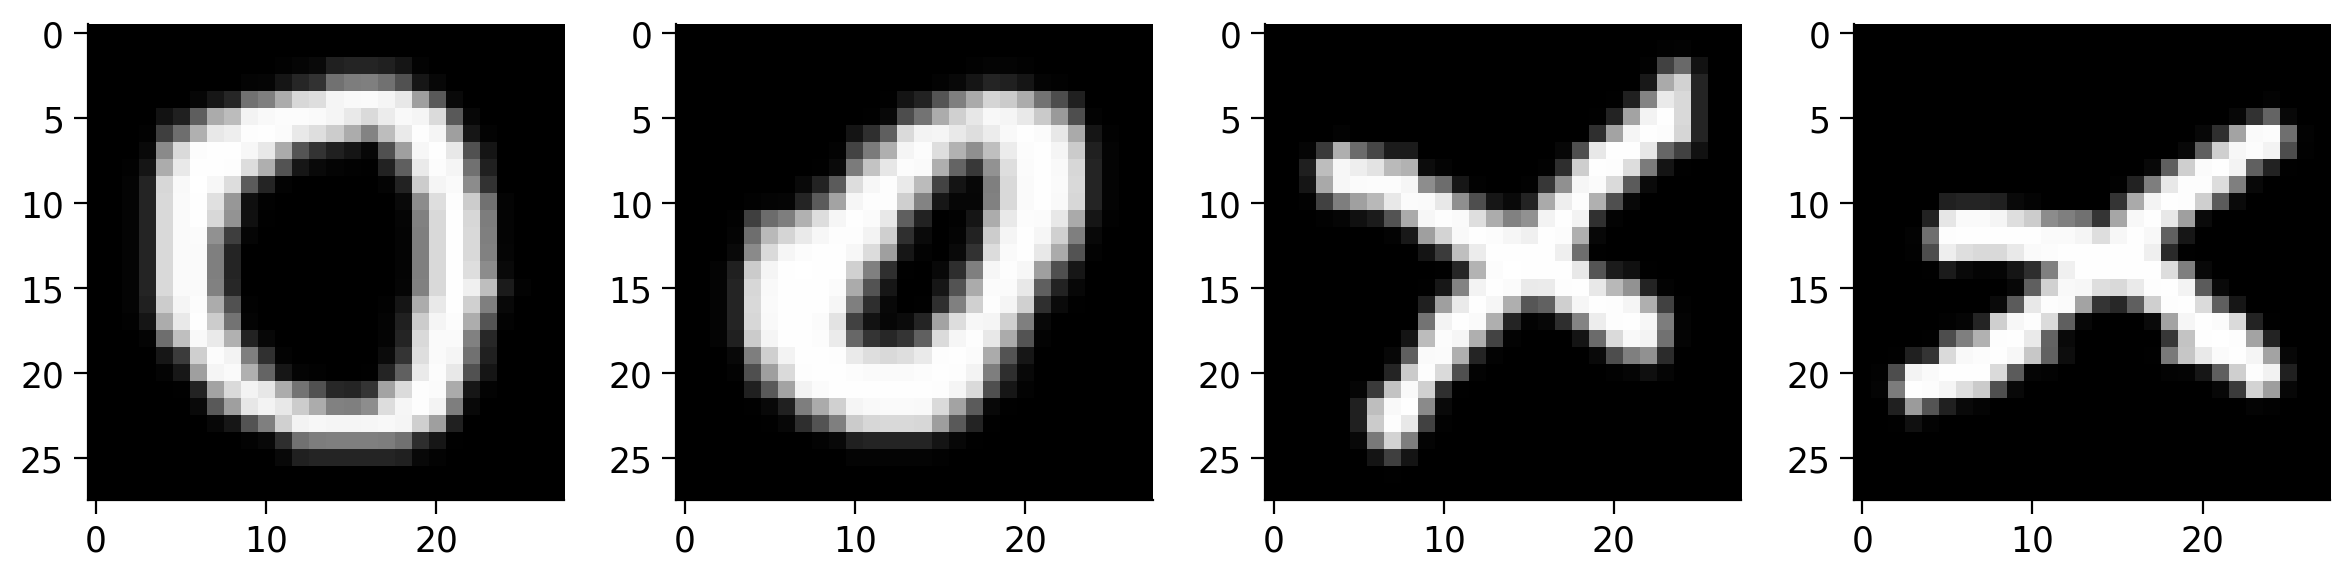

In [23]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(12, 6))
ax1.imshow(emnist_train[0][0].reshape(28, 28), cmap='gray')
ax2.imshow(emnist_train[10][0].reshape(28, 28), cmap='gray')
ax3.imshow(emnist_train[4][0].reshape(28, 28), cmap='gray')
ax4.imshow(emnist_train[6][0].reshape(28, 28), cmap='gray')
plt.show()

## Interactive Demo 2: Visualization of Convolution with Multiple Filters

Change the number of input channels (e.g., the color channels of an image or the output channels of a previous layer) and the output channels (number of different filters to apply).

**Important:** Change the bool variable `run_demo` to `True` by ticking the box, in order to experiment with the demo. Due to video rendering on jupyter-book, we had to remove it from the automatic execution.

In [24]:
# @markdown *Run this cell to enable the widget!*

from IPython.display import HTML

id_html = 3
url = f'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/interactive_demo{id_html}.html'
run_demo = True # @param {type:"boolean"}
if run_demo:
  display(HTML(url))

## Section 2.1: Multiple Filters

The following network sets up 3 filters and runs them on an image of the dataset from the $X$ class. Note that we are using "thicker" filters than those presented in the videos. Here, the filters are $5 \times 5$, whereas in the videos $3 \times 3$.

In [25]:
class Net2(nn.Module):
  """
  Neural Network instance
  """

  def __init__(self, padding=0):
    """
    Initialize parameters of Net2

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0

    Returns:
      Nothing
    """
    super(Net2, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel - leading diagonal
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # tThird kernel - checkerboard pattern
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net2

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    x = self.conv1(x)
    return x

**Note:** We add a negative bias to give a threshold to select the high output value, which corresponds to the features we want to detect (e.g., 45 degree oriented bar).

Now, let's visualize the filters using the code given below.

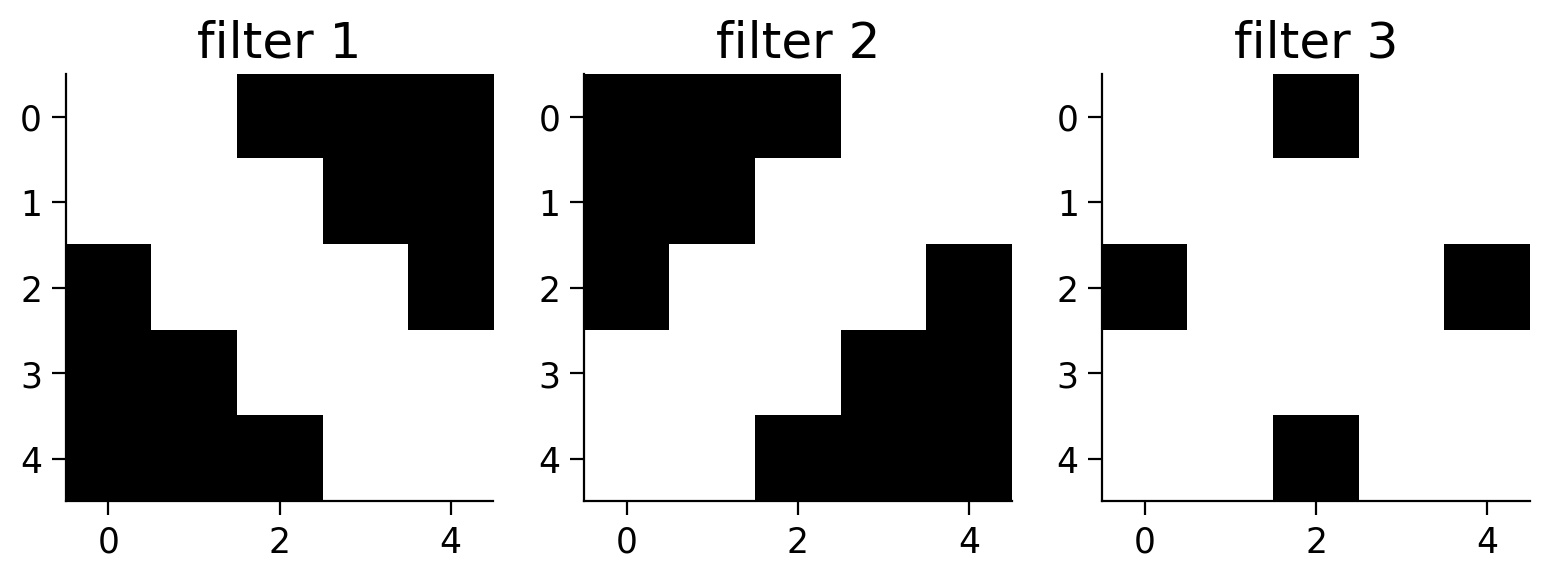

In [26]:
net2 = Net2().to(DEVICE)
fig, (ax11, ax12, ax13) = plt.subplots(1, 3)
# Show the filters
ax11.set_title("filter 1")
ax11.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax12.set_title("filter 2")
ax12.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 3")
ax13.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

### Think! 2.1: Do you see how these filters would help recognize an `X`?

In [27]:
"""
TODO: Add Explanation
""";

We apply the filters to the images.

In [28]:
net2 = Net2().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x = net2(x_img)
output_x = output_x.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o = net2(o_img)
output_o = output_o.squeeze(dim=0).detach().cpu().numpy()

Let us view the image of $X$ and $O$ and what the output of the filters applied to them looks like. Pay special attention to the areas with very high vs. very low output patterns.

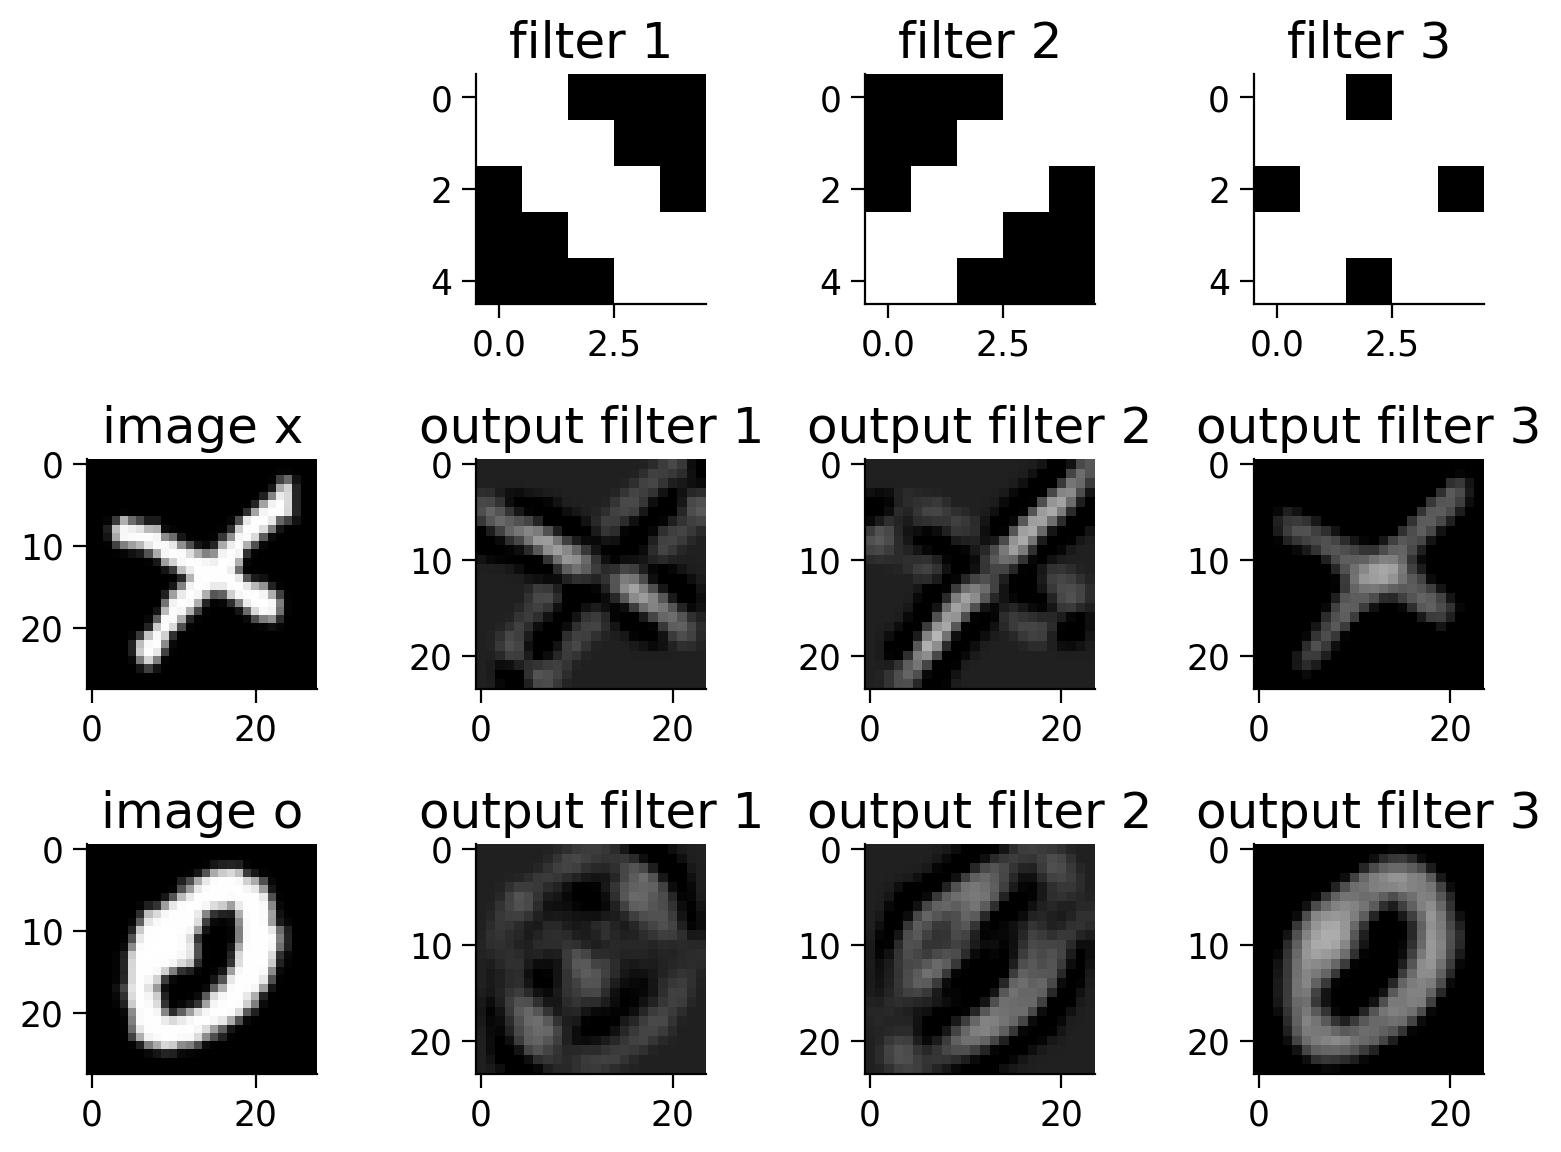

In [29]:
fig, ((ax11, ax12, ax13, ax14),
      (ax21, ax22, ax23, ax24),
      (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4)

# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net2.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net2.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net2.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to x
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to o
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

## Section 2.2: ReLU after convolutions

Up until now we've talked about the convolution operation, which is linear. But the real strength of neural networks comes from the incorporation of non-linear functions.  Furthermore, in the real world, we often have learning problems where the relationship between the input and output is non-linear and complex.

The ReLU (Rectified Linear Unit) introduces non-linearity into our model, allowing us to learn a more complex function that can better predict the class of an image.

The ReLU function is shown below.

<br>

<figure>
  <center><img src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/relu.png width=400px>
  <figcaption>The Rectified Linear Unit (ReLU) Activation Function<figcaption>
  </center>
</figure>

Now let us incorporate ReLU into our previous model and visualize the output.

In [30]:
class Net3(nn.Module):
  """
  Neural Network Instance
  """

  def __init__(self, padding=0):
    """
    Initialize Net3 parameters

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0

    Returns:
      Nothing
    """
    super(Net3, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                           padding=padding)

    # First kernel - leading diagonal
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel -checkerboard pattern
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))

  def forward(self, x):
    """
    Forward Pass of Net3

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution output
    """
    x = self.conv1(x)
    x = F.relu(x)
    return x

We apply the filters and relus to the images.

In [31]:
net3 = Net3().to(DEVICE)
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_x_relu = net3(x_img)
output_x_relu = output_x_relu.squeeze(dim=0).detach().cpu().numpy()

o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
output_o_relu = net3(o_img)
output_o_relu = output_o_relu.squeeze(dim=0).detach().cpu().numpy()

Let us view the image of $X$ and $O$ and what the output of the filters applied to them look like.

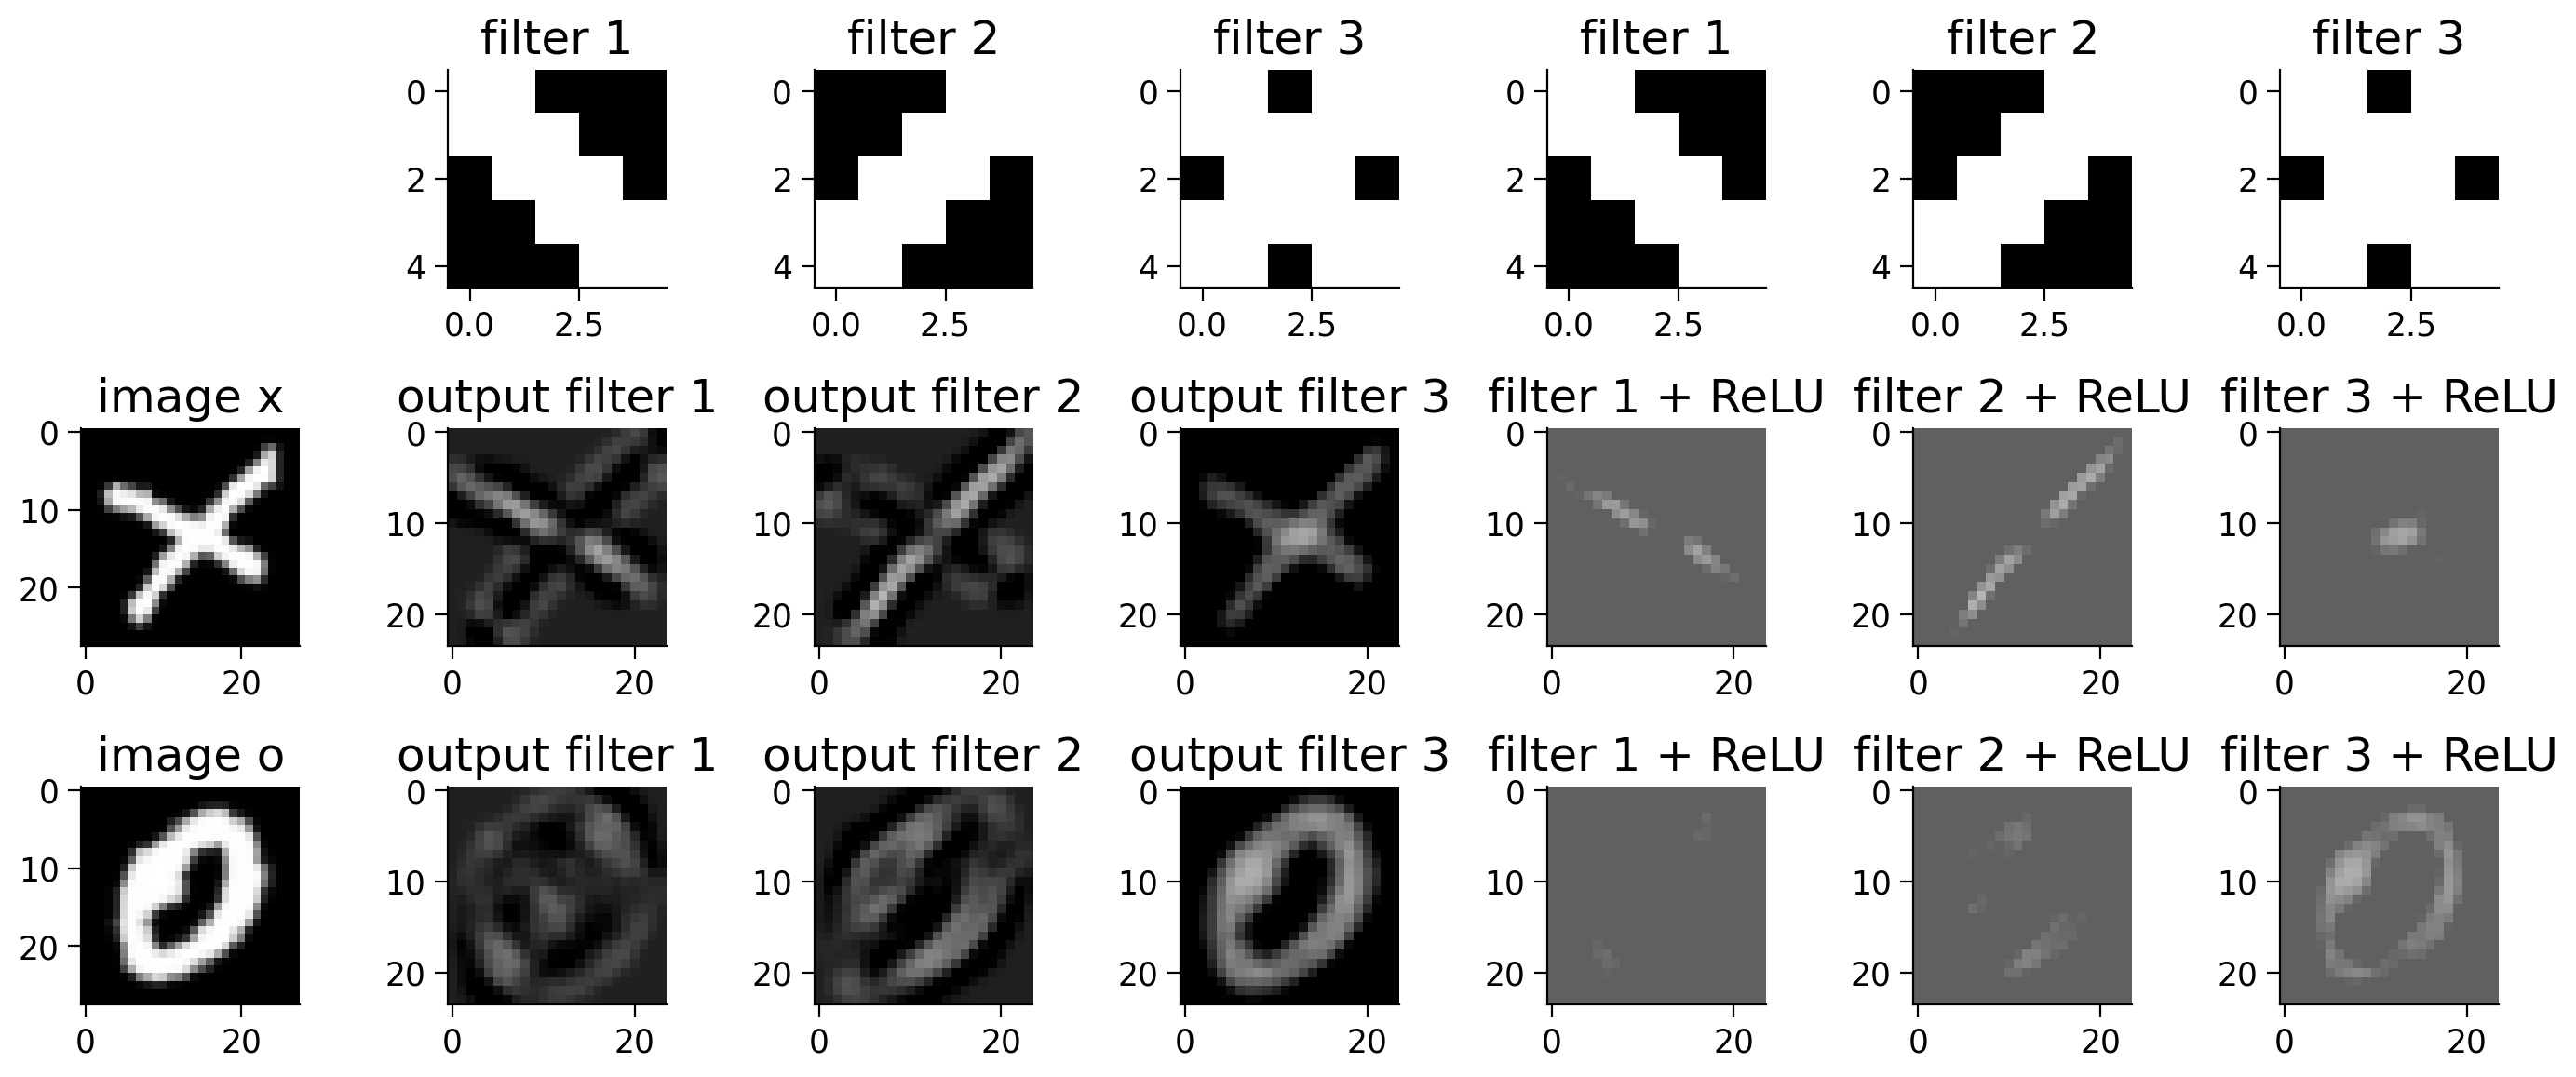

In [32]:
# @markdown *Execute this cell to view the filtered images*
fig, ((ax11, ax12, ax13, ax14, ax15, ax16, ax17),
      (ax21, ax22, ax23, ax24, ax25, ax26, ax27),
      (ax31, ax32, ax33, ax34, ax35, ax36, ax37)) = plt.subplots(3, 4 + 3,
                                                                 figsize=(14, 6))
# Show the filters
ax11.axis("off")
ax12.set_title("filter 1")
ax12.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax13.set_title("filter 2")
ax13.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax14.set_title("filter 3")
ax14.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

ax15.set_title("filter 1")
ax15.imshow(net3.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
ax16.set_title("filter 2")
ax16.imshow(net3.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
ax17.set_title("filter 3")
ax17.imshow(net3.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

vmin, vmax = -6, 10
# Show x and the filters applied to `x`
ax21.set_title("image x")
ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
ax22.set_title("output filter 1")
ax22.imshow(output_x[0], cmap='gray', vmin=vmin, vmax=vmax)
ax23.set_title("output filter 2")
ax23.imshow(output_x[1], cmap='gray', vmin=vmin, vmax=vmax)
ax24.set_title("output filter 3")
ax24.imshow(output_x[2], cmap='gray', vmin=vmin, vmax=vmax)

ax25.set_title("filter 1 + ReLU")
ax25.imshow(output_x_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax26.set_title("filter 2 + ReLU")
ax26.imshow(output_x_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax27.set_title("filter 3 + ReLU")
ax27.imshow(output_x_relu[2], cmap='gray', vmin=vmin, vmax=vmax)

# Show o and the filters applied to `o`
ax31.set_title("image o")
ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
ax32.set_title("output filter 1")
ax32.imshow(output_o[0], cmap='gray', vmin=vmin, vmax=vmax)
ax33.set_title("output filter 2")
ax33.imshow(output_o[1], cmap='gray', vmin=vmin, vmax=vmax)
ax34.set_title("output filter 3")
ax34.imshow(output_o[2], cmap='gray', vmin=vmin, vmax=vmax)

ax35.set_title("filter 1 + ReLU")
ax35.imshow(output_o_relu[0], cmap='gray', vmin=vmin, vmax=vmax)
ax36.set_title("filter 2 + ReLU")
ax36.imshow(output_o_relu[1], cmap='gray', vmin=vmin, vmax=vmax)
ax37.set_title("filter 3 + ReLU")
ax37.imshow(output_o_relu[2], cmap='gray', vmin=vmin, vmax=vmax)
plt.show()

Discuss with your pod how the ReLU activations help strengthen the features necessary to detect an $X$.

<br>

[Here](https://stats.stackexchange.com/a/226927) you can found a discussion which talks about how ReLU is useful as an activation funciton.

[Here](https://stats.stackexchange.com/questions/126238/what-are-the-advantages-of-relu-over-sigmoid-function-in-deep-neural-networks?sfb=2) you can found a another excellent discussion about the advantages of using ReLU.

## Section 2.3: Pooling

Convolutional layers create feature maps that summarize the presence of particular features (e.g., edges) in the input. However, these feature maps record the _precise_ position of features in the input. That means that small changes to the position of an object in an image can result in a very different feature map. But a cup is a cup (and an $X$ is an $X$) no matter where it appears in the image!  We need to achieve _translational invariance_.

A common approach to this problem is called downsampling. Downsampling creates a lower-resolution version of an image, retaining the large structural elements and removing some of the fine detail that may be less relevant to the task. In CNNs, Max-Pooling and Average-Pooling are used to downsample.  These operations shrink the size of the hidden layers, and produce features that are more translationally invariant, which can be better leveraged by subsequent layers.

Like convolutional layers, pooling layers have fixed-shape windows (pooling windows) that are systematically applied to the input.  As with filters, we can change the shape of the window and the size of the stride.  And, just like with filters, every time we apply a pooling operation we produce a single output.

Pooling performs a kind of information compression that provides summary statistics for a _neighborhood_ of the input.
- In Maxpooling, we compute the maximum value of all pixels in the pooling window.
- In Avgpooling, we compute the average value of all pixels in the pooling window.

The example below shows the result of Maxpooling within the yellow pooling windows to create the red pooling output matrix.

<figure>
    <center><img src=https://developers.google.com/machine-learning/glossary/images/PoolingConvolution.svg?hl=fr width=400px>
    <figcaption>An Example of Pooling with a kernel size of 2</figcaption>
    </center>
</figure>

Pooling gives our network translational invariance by providing a summary of the values in each pooling window. Thus, a small change in the features of the underlying image won't make a huge difference to the output.

Note that, unlike a convolutional layer, the pooling layer contains no learned parameters! Pooling just computes a pre-determined summary of the input and passes that along.  This is in contrast to the convolutional layer, where there are filters to be learned.


### Interactive Demo 2.3: The effect of the stride

**Important:** Change the bool variable `run_demo` to `True` by ticking the box, in order to experiment with the demo. Due to video rendering on jupyter-book, we had to remove it from the automatic execution.

The following animation depicts how changing the stride changes the output. The stride defines how much the pooling region is moved over the input matrix to produce the next output (red arrows in the animation).  Give it a try! Change the stride and see how it affects the output shape.  You can also try MaxPool or AvgPool.


In [33]:
# @markdown *Run this cell to enable the widget!*

from IPython.display import HTML

id_html = 3.3
url = f'https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/interactive_demo{id_html}.html'
run_demo = True # @param {type:"boolean"}
if run_demo:
  display(HTML(url))

### Coding Exercise 2.3: Implement MaxPooling

Let us now implement MaxPooling in PyTorch and observe the effects of Pooling on the dimension of the input image. Use a kernel of size 2 and stride of 2 for the MaxPooling layer.

```python
class Net4(nn.Module):
  """
  Neural Network instance
  """

  def __init__(self, padding=0, stride=2):
    """
    Initialise parameters of Net4

    Args:
      padding: int or tuple, optional
        Zero-padding added to both sides of the input. Default: 0
      stride: int
        Stride

    Returns:
      Nothing
    """
    super(Net4, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=3, kernel_size=5,
                            padding=padding)

    # First kernel - leading diagonal
    kernel_1 = torch.Tensor([[[1., 1., -1., -1., -1.],
                              [1., 1., 1., -1., -1.],
                              [-1., 1., 1., 1., -1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., -1., -1., 1., 1.]]])

    # Second kernel - other diagonal
    kernel_2 = torch.Tensor([[[-1., -1., -1., 1., 1.],
                              [-1., -1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., -1., -1.],
                              [1., 1., -1., -1., -1.]]])

    # Third kernel -checkerboard pattern
    kernel_3 = torch.Tensor([[[1., 1., -1., 1., 1.],
                              [1., 1., 1., 1., 1.],
                              [-1., 1., 1., 1., -1.],
                              [1., 1., 1., 1., 1.],
                              [1., 1., -1., 1., 1.]]])


    # Stack all kernels in one tensor with (3, 1, 5, 5) dimensions
    multiple_kernels = torch.stack([kernel_1, kernel_2, kernel_3], dim=0)

    self.conv1.weight = torch.nn.Parameter(multiple_kernels)

    # Negative bias
    self.conv1.bias = torch.nn.Parameter(torch.Tensor([-4, -4, -12]))
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    self.pool = nn.MaxPool2d(kernel_size=..., stride=...)

  def forward(self, x):
    """
    Forward Pass of Net4

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Convolution + ReLU output
    """
    x = self.conv1(x)
    x = F.relu(x)
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the maxpool layer")
    ####################################################################
    x = ...  # Pass through a max pool layer
    return x



## Check if your implementation is correct
# net4 = Net4().to(DEVICE)
# check_pooling_net(net4, device=DEVICE)

```

```
✅ Your network produced the correct output.
```

In [34]:
# TODO: Complete previous code

In [35]:
try:
    x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
    output_x_pool = net4(x_img)
    output_x_pool = output_x_pool.squeeze(dim=0).detach().cpu().numpy()

    o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
    output_o_pool = net4(o_img)
    output_o_pool = output_o_pool.squeeze(dim=0).detach().cpu().numpy()
except NameError as e:
    print(f"Error No Implemented Class.")

Error No Implemented Class.


Error No Implemented Class.


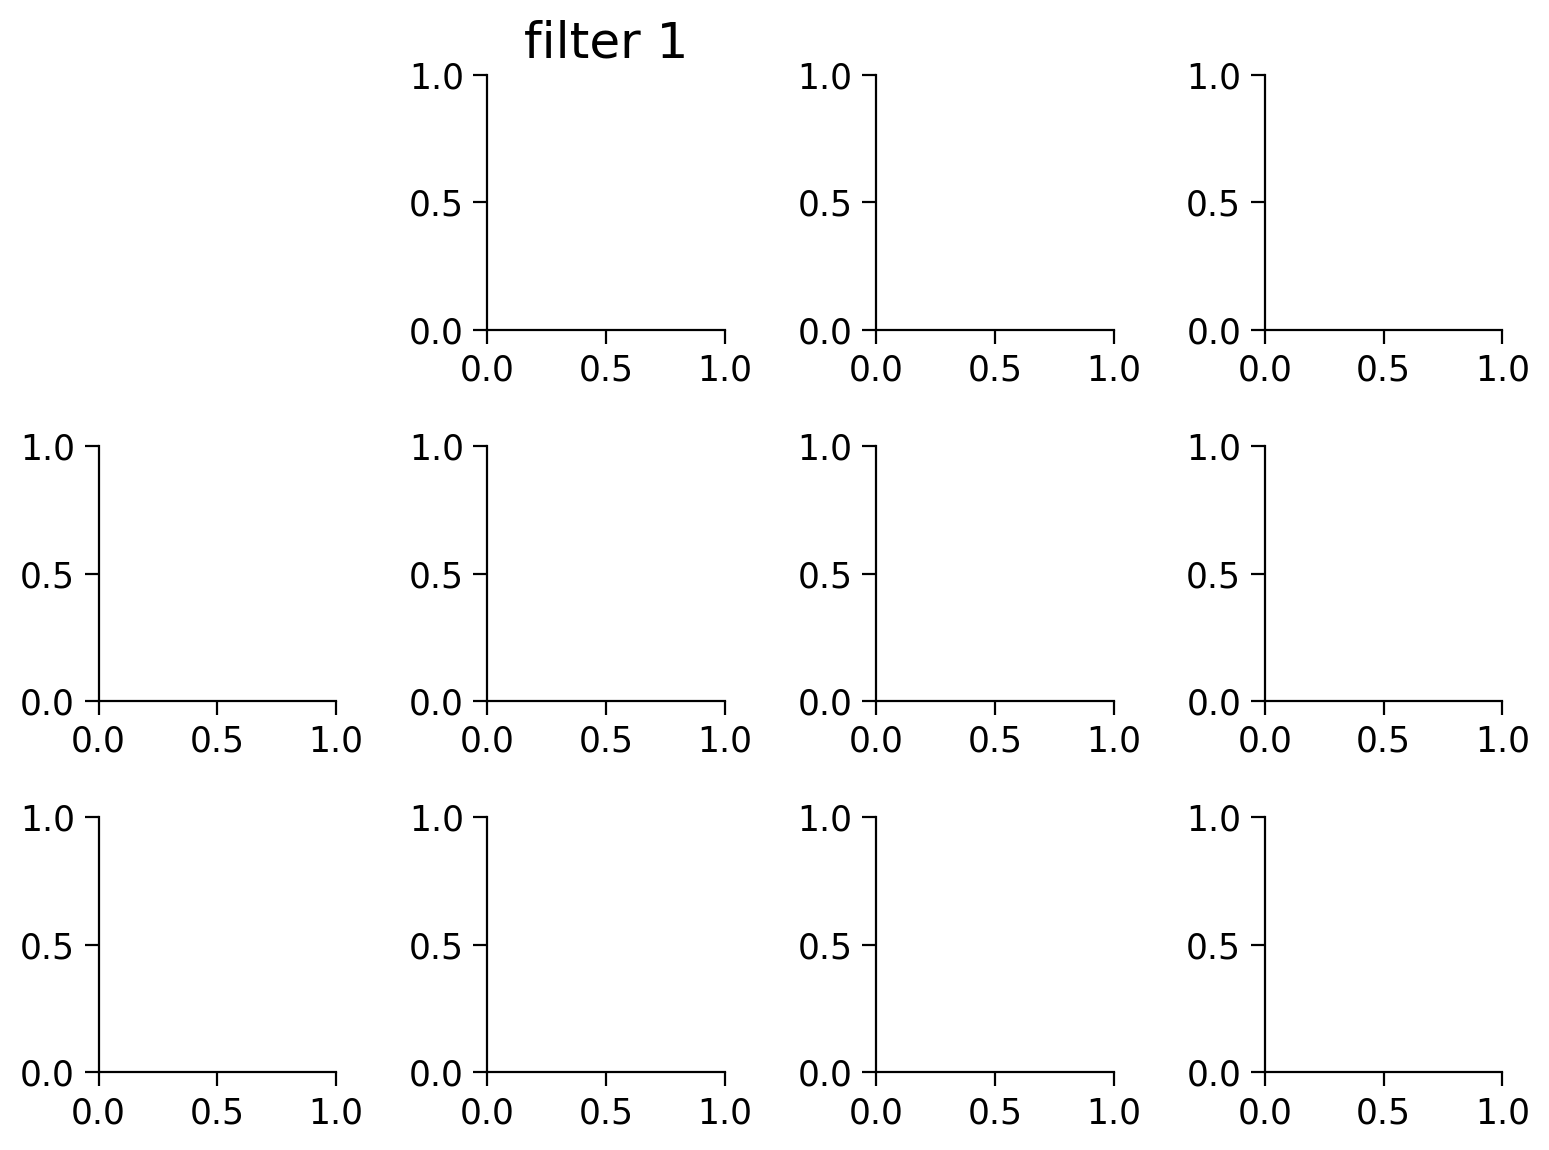

In [36]:
try:
    # @markdown *Run the cell to plot the outputs!*

    fig, ((ax11, ax12, ax13, ax14),
          (ax21, ax22, ax23, ax24),
          (ax31, ax32, ax33, ax34)) = plt.subplots(3, 4)
    # Show the filters
    ax11.axis("off")
    ax12.set_title("filter 1")
    ax12.imshow(net4.conv1.weight[0, 0].detach().cpu().numpy(), cmap="gray")
    ax13.set_title("filter 2")
    ax13.imshow(net4.conv1.weight[1, 0].detach().cpu().numpy(), cmap="gray")
    ax14.set_title("filter 3")
    ax14.imshow(net4.conv1.weight[2, 0].detach().cpu().numpy(), cmap="gray")

    vmin, vmax = -6, 10
    # Show x and the filters applied to x
    ax21.set_title("image x")
    ax21.imshow(emnist_train[x_img_idx][0].reshape(28, 28), cmap='gray')
    ax22.set_title("output filter 1")
    ax22.imshow(output_x_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
    ax23.set_title("output filter 2")
    ax23.imshow(output_x_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
    ax24.set_title("output filter 3")
    ax24.imshow(output_x_pool[2], cmap='gray', vmin=vmin, vmax=vmax)

    # Show o and the filters applied to o
    ax31.set_title("image o")
    ax31.imshow(emnist_train[o_img_idx][0].reshape(28, 28), cmap='gray')
    ax32.set_title("output filter 1")
    ax32.imshow(output_o_pool[0], cmap='gray', vmin=vmin, vmax=vmax)
    ax33.set_title("output filter 2")
    ax33.imshow(output_o_pool[1], cmap='gray', vmin=vmin, vmax=vmax)
    ax34.set_title("output filter 3")
    ax34.imshow(output_o_pool[2], cmap='gray', vmin=vmin, vmax=vmax)
    plt.show()
except NameError as e:
    print(f"Error No Implemented Class.")

You should observe the size of the output as being half of what you saw after the ReLU section, which is due to the Maxpool layer.

Despite the reduction in the size of the output, the important or high-level features in the output still remains intact.

---
# Section 3: Putting it all together


## Section 3.1: Number of Parameters in Convolutional vs. Fully-connected Models
Convolutional networks encourage weight-sharing by learning a single kernel that is repeated over the entire input image. In general, this kernel is just a few parameters, compared to the huge number of parameters in a dense network.

Let's use the animation below to calculate few-layer network parameters for image data of shape $32\times32$ using both convolutional layers and dense layers. The `Num_Dense` in this exercise is the number of dense layers we use in the network, with each dense layer having the same input and output dimensions. `Num_Convs` is the number of convolutional blocks in the network, with each block containing a single kernel. The kernel size is the length and width of this kernel.

**Note:** you must run the cell before you can use the sliders.

<br>
<center>
  <img src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W2D2_ConvnetsAndDlThinking/static/img_params.png>
  <figcaption> Parameter comparison</figcaption>
</center>


### Interactive Demo 3.1: Number of Parameters

In [37]:
# @markdown *Run this cell to enable the widget*
import io, base64
from ipywidgets import interact, interactive, fixed, interact_manual


def do_plot(image_size, batch_size, number_of_Linear, number_of_Conv2d,
            kernel_size, pooling, Final_Layer):
  sample_image = torch.rand(batch_size, 1, image_size, image_size)
  linear_layer = []
  linear_nets = []
  code_dense = ""

  code_dense += f"model_dense = nn.Sequential(\n"
  code_dense += f"    nn.Flatten(),\n"
  for i in range(number_of_Linear):
    linear_layer.append(nn.Linear(image_size * image_size * 1,
                                  image_size * image_size * 1,
                                  bias=False))
    linear_nets.append(nn.Sequential(*linear_layer))
    code_dense += f"    nn.Linear({image_size}*{image_size}*1, {image_size}*{image_size}*1, bias=False),\n"
  if Final_Layer is True:
    linear_layer.append(nn.Linear(image_size * image_size * 1, 10,
                                  bias=False))
    linear_nets.append(nn.Sequential(*linear_layer))
    code_dense += f"    nn.Linear({image_size}*{image_size}*1, 10, bias=False)\n"
  code_dense += ")\n"
  code_dense += "result_dense = model_dense(sample_image)\n"
  linear_layer = nn.Sequential(*linear_layer)

  conv_layer = []
  conv_nets = []
  code_conv = ""

  code_conv += f"model_conv = nn.Sequential(\n"
  for i in range(number_of_Conv2d):
    conv_layer.append(nn.Conv2d(in_channels=1,
                                out_channels=1,
                                kernel_size=kernel_size,
                                padding=kernel_size // 2,
                                bias=False))

    conv_nets.append(nn.Sequential(*conv_layer))
    code_conv += f"    nn.Conv2d(in_channels=1, out_channels=1, kernel_size={kernel_size}, padding={kernel_size//2}, bias=False),\n"
    if pooling > 0:
      conv_layer.append(nn.MaxPool2d(2, 2))
      code_conv += f"    nn.MaxPool2d(2, 2),\n"
    conv_nets.append(nn.Sequential(*conv_layer))
  if Final_Layer is True:
    conv_layer.append(nn.Flatten())
    code_conv += f"    nn.Flatten(),\n"
    conv_nets.append(nn.Sequential(*conv_layer))
    shape_conv = conv_nets[-1](sample_image).shape
    conv_layer.append(nn.Linear(shape_conv[1], 10, bias=False))
    code_conv += f"    nn.Linear({shape_conv[1]}, 10, bias=False),\n"
    conv_nets.append(nn.Sequential(*conv_layer))
  conv_layer = nn.Sequential(*conv_layer)
  code_conv += ")\n"
  code_conv += "result_conv = model_conv(sample_image)\n"


  t_1 = time.time()
  shape_linear = linear_layer(torch.flatten(sample_image, 1)).shape
  t_2 = time.time()
  shape_conv = conv_layer(sample_image).shape
  t_3 = time.time()

  print("Time taken by Dense Layer {}".format(t_2 - t_1))
  print("Time taken by Conv Layer  {}".format(t_3 - t_2))

  ax = plt.axes((0, 0, 1, 1))
  ax.spines["left"].set_visible(False)
  plt.yticks([])
  ax.spines["bottom"].set_visible(False)
  ax.spines["right"].set_visible(False)
  ax.spines["top"].set_visible(False)
  plt.xticks([])
  p1 = sum(p.numel() for p in linear_layer.parameters())
  nl = '\n'
  p2 = sum(p.numel() for p in conv_layer.parameters())
  plt.text(0.1, 0.8,
           f"Total Parameters in Dense Layer {p1:10,d}{nl}Total Parameters in Conv Layer   {p2:10,d}")

  plt.text(0.23, 0.62, "Dense Net", rotation=90,
           color='k', ha="center", va="center")

  def addBox(x, y, w, h, color, text1, text2, text3):
      """
      Function to render widget
      """
      ax.add_patch(plt.Rectangle((x, y), w, h, fill=True, color=color,
                                 alpha=0.5, zorder=1000, clip_on=False))
      plt.text(x + 0.02, y + h / 2, text1, rotation=90,
               va="center", ha="center", size=12)
      plt.text(x + 0.05, y + h / 2, text2, rotation=90,
               va="center", ha="center")
      plt.text(x + 0.08, y + h / 2, text3, rotation=90,
               va="center", ha="center", size=12)

  x = 0.25
  if 1:
    addBox(x, 0.5, 0.08, 0.25, [1, 0.5, 0], "Flatten",
           tuple(torch.flatten(sample_image, 1).shape), "")
    x += 0.08 + 0.01

  for i in range(number_of_Linear):
    addBox(x, 0.5, 0.1, 0.25, "g", "Dense",
           tuple(linear_nets[i](torch.flatten(sample_image, 1)).shape),
           list(linear_layer.parameters())[i].numel())
    x += 0.11

  if Final_Layer is True:
    i = number_of_Linear
    addBox(x, 0.5, 0.1, 0.25, "g", "Dense",
           tuple(linear_nets[i](torch.flatten(sample_image, 1)).shape),
           list(linear_layer.parameters())[i].numel())

  plt.text(0.23, 0.1 + 0.35 / 2, "Conv Net",
           rotation=90, color='k',
           ha="center", va="center")
  x = 0.25

  for i in range(number_of_Conv2d):
    addBox(x, 0.1, 0.1, 0.35, "r", "Conv",
           tuple(conv_nets[i * 2](sample_image).shape),
           list(conv_nets[i * 2].parameters())[-1].numel())
    x += 0.11
    if pooling > 0:
      addBox(x, 0.1, 0.08, 0.35, [0, 0.5, 1], "Pooling",
             tuple(conv_nets[i * 2 + 1](sample_image).shape), "")
      x += 0.08 + 0.01

  if Final_Layer is True:
    i = number_of_Conv2d
    addBox(x, 0.1, 0.08, 0.35, [1, 0.5, 0], "Flatten",
           tuple(conv_nets[i * 2](sample_image).shape), "")
    x += 0.08 + 0.01

    addBox(x, 0.1, 0.1, 0.35, "g", "Dense",
            tuple(conv_nets[i * 2 + 1](sample_image).shape),
            list(conv_nets[i * 2 + 1].parameters())[-1].numel())
    x += 0.11

  plt.text(0.08, 0.3 + 0.35 / 2,
           "Input", rotation=90, color='b', ha="center", va="center")

  ax.add_patch(plt.Rectangle((0.1, 0.3), 0.1, 0.35, fill=True, color='b',
                             alpha=0.5, zorder=1000, clip_on=False))
  plt.text(0.1 + 0.1 / 2, 0.3 + 0.35 / 2, tuple(sample_image.shape),
           rotation=90, va="center", ha="center")

  # Plot
  plt.gcf().set_tight_layout(False)
  my_stringIObytes = io.BytesIO()
  plt.savefig(my_stringIObytes, format='png', dpi=90)
  my_stringIObytes.seek(0)
  my_base64_jpgData = base64.b64encode(my_stringIObytes.read())

  del linear_layer, conv_layer

  plt.close()
  mystring = """<img src="data:image/png;base64,""" + str(my_base64_jpgData)[2:-1] + """" alt="Graph">"""

  return code_dense, code_conv, mystring


# Parameters
caption = widgets.Label(value='The values of range1 and range2 are synchronized')
slider_batch_size = widgets.IntSlider(value=100, min=10, max=100, step=10,
                                      description="BatchSize")
slider_image_size = widgets.IntSlider(value=32, min=32, max=128, step=32,
                                      description="ImageSize")
slider_number_of_Linear = widgets.IntSlider(value=1,min=1, max=3, step=1,
                                            description="NumDense")
slider_number_of_Conv2d = widgets.IntSlider(value=1, min=1, max=2, step=1,
                                            description="NumConv")
slider_kernel_size = widgets.IntSlider(value=5, min=3, max=21, step=2,
                                       description="KernelSize")
input_pooling = widgets.Checkbox(value=False,
                                 description="Pooling")
input_Final_Layer = widgets.Checkbox(value=False,
                                     description="Final_Layer")

output_code1 = widgets.HTML(value="", )

output_plot = widgets.HTML(value="", )


def plot_func(batch_size, image_size,
              number_of_Linear, number_of_Conv2d,
              kernel_size, pooling, Final_Layer):

    code1, code2, plot = do_plot(image_size, batch_size,
                                 number_of_Linear, number_of_Conv2d,
                                 kernel_size, pooling, Final_Layer)
    output_plot.value = plot

    output_code1.value = """
    <!DOCTYPE html>
    <html>
      <head>
        <style>
          * {
            box-sizing: border-box;
          }
          .column {
            float: left;
            /*width: 33.33%;*/
            padding: 5px;
          }
          /* Clearfix (clear floats) */
          .row::after {
            content: "";
            clear: both;
            display: table;
          }
          pre {
            line-height: 1.2em;
          }
        </style>
      </head>

      <body>
        <div class="row">
          <div class="column" style="overflow-x: scroll;">
          <h2>Code for Dense Network</h2>
          <pre>""" + code1 + """</pre>
        </div>
          <div class="column" style="overflow-x: scroll;">
          <h2>Code for Conv Network</h2>
          <pre>""" + code2 + """</pre>
          </div>
        </div>
      </body>
    </html>
"""

out = widgets.interactive_output(plot_func, {
    "batch_size": slider_batch_size,
    "image_size": slider_image_size,
    "number_of_Linear": slider_number_of_Linear,
    "number_of_Conv2d": slider_number_of_Conv2d,
    "kernel_size": slider_kernel_size,
    "pooling": input_pooling,
    "Final_Layer": input_Final_Layer,
})

ui = widgets.VBox([slider_batch_size, slider_image_size,
                   slider_number_of_Linear,
                   widgets.HBox([slider_number_of_Conv2d,
                                 slider_kernel_size,
                                 input_pooling]),
                   input_Final_Layer])
display(widgets.HBox([output_plot, output_code1]), ui)
display(out)

Output()

The difference in parameters is huge, and it continues to increase as the input image size increases. Larger images require that the linear layer use a matrix that can be directly multiplied with the input pixels.

<br>

While pooling does not reduce the number of parameters for a subsequent convolutional layer, it does decreases the image size. Therefore, later dense layers will need fewer parameters.

<br>

The CNN parameter size, however, is invariant of the image size, as irrespective of the input that it gets, it keeps sliding the same learnable filter over the images.

The reduced parameter set not only brings down memory usage by huge chunks, but it also allows the model to generalize better.


## Coding Exercise 4: Implement your own CNN

Let's stack up all we have learnt. Create a CNN with the following structure. <br>
- Convolution `nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)`
- Convolution `nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)`
- Pool Layer `nn.MaxPool2d(kernel_size=2)`
- Fully Connected Layer `nn.Linear(in_features=9216, out_features=128)`
- Fully Connected layer `nn.Linear(in_features=128, out_features=2)`

Note: As discussed in the video, we would like to flatten the output from the Convolutional Layers before passing on the Linear layers, thereby converting an input of shape $[\text{BatchSize}, \text{Channels}, \text{Height}, \text{Width}]$ to $[\text{BatchSize}, \text{Channels} \times \text{Height} \times \text{Width}]$, which in this case would be from $[32, 64, 12, 12]$ (output of second convolution layer) to $[32, 64 \times 12 \times 12] = [32, 9216]$. Recall that the input images have size $[28, 28]$.

Hint: You could use `torch.flatten(x, 1)` in order to flatten the input at this stage. The $1$ means it flattens dimensions starting with dimensions 1 in order to exclude the batch dimension from the flattening.

We should also stop to think about how we get the output of the pooling layer to be $12 \times 12$. It is because first, the two `Conv2d` with a `kernel_size=3` operations cause the image to be reduced to $26 \times 26$ and the second `Conv2d` reduces it to $24 \times 24$. Finally, the `MaxPool2d` operation reduces the output size by half to $12 \times 12$.

Also, don't forget the ReLUs (use e.g., `F.ReLU`)! No need to add a ReLU after the final fully connected layer.



In [38]:
# @title Train/Test Functions (Run Me)

# @markdown Double-click to see the contents!

def train(model, device, train_loader, epochs):
  """
  Training function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    epochs: int
      Number of epochs
    train_loader: torch.loader
      Training Set

  Returns:
    Nothing
  """
  model.train()

  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
  for epoch in range(epochs):
    with tqdm(train_loader, unit='batch') as tepoch:
      for data, target in tepoch:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)

        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        tepoch.set_postfix(loss=loss.item())
        time.sleep(0.1)

def test(model, device, data_loader):
  """
  Test function

  Args:
    model: nn.module
      Neural network instance
    device: string
      GPU/CUDA if available, CPU otherwise
    data_loader: torch.loader
      Test Set

  Returns:
    acc: float
      Test accuracy
  """
  model.eval()
  correct = 0
  total = 0
  for data in data_loader:
    inputs, labels = data
    inputs = inputs.to(device).float()
    labels = labels.to(device).long()

    outputs = model(inputs)
    _, predicted = torch.max(outputs, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  acc = 100 * correct / total
  return acc

We download the data. Notice that here, we normalize the dataset.

In [39]:
set_seed(SEED)
emnist_train, emnist_test = get_Xvs0_dataset(normalize=True)
train_loader, test_loader = get_data_loaders(emnist_train, emnist_test,
                                             seed=SEED)

Random seed 2021 has been set.


```python
class EMNIST_Net(nn.Module):
  """
  Neural network instance with following structure
  nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3) # Convolutional Layer 1
  nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3) + max-pooling # Convolutional Block 2
  nn.Linear(in_features=9216, out_features=128) # Fully Connected Layer 1
  nn.Linear(in_features=128, out_features=2) # Fully Connected Layer 2
  """

  def __init__(self):
    """
    Initialize parameters of EMNISTNet

    Args:
      None

    Returns:
      Nothing
    """
    super(EMNIST_Net, self).__init__()

    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    raise NotImplementedError("Define the required layers")
    ####################################################################
    self.conv1 = nn.Conv2d(...)
    self.conv2 = nn.Conv2d(...)
    self.fc1 = nn.Linear(...)
    self.fc2 = nn.Linear(...)
    self.pool = nn.MaxPool2d(...)

  def forward(self, x):
    """
    Forward pass of EMNISTNet

    Args:
      x: torch.tensor
        Input features

    Returns:
      x: torch.tensor
        Output of final fully connected layer
    """
    ####################################################################
    # Fill in missing code below (...),
    # then remove or comment the line below to test your function
    # Hint: Do not forget to flatten the image as it goes from
    # Convolution Layers to Linear Layers!
    raise NotImplementedError("Define forward pass for any input x")
    ####################################################################
    x = self.conv1(x)
    x = F.relu(x)
    x = self.conv2(x)
    x = ...
    x = ...
    x = ...
    x = ...
    x = ...
    x = ...
    return x



## Uncomment the lines below to train your network
# emnist_net = EMNIST_Net().to(DEVICE)
# print("Total Parameters in Network {:10d}".format(sum(p.numel() for p in emnist_net.parameters())))
# train(emnist_net, DEVICE, train_loader, 1)
## Uncomment to test your model
# print(f'Test accuracy is: {test(emnist_net, DEVICE, test_loader)}')

```

You should have been able to get a test accuracy of around $99%$!
# Activity 9
Please, develop the previous coding exercise. Then, compute its test accuracy and submit it on [AhaSlides](https://ahaslides.com/33NB8).

In [40]:
# TODO: Complete previous code

**Note:** We are using a softmax function here which converts a real value to a value between 0 and 1, which can be interpreted as a probability.

Input:


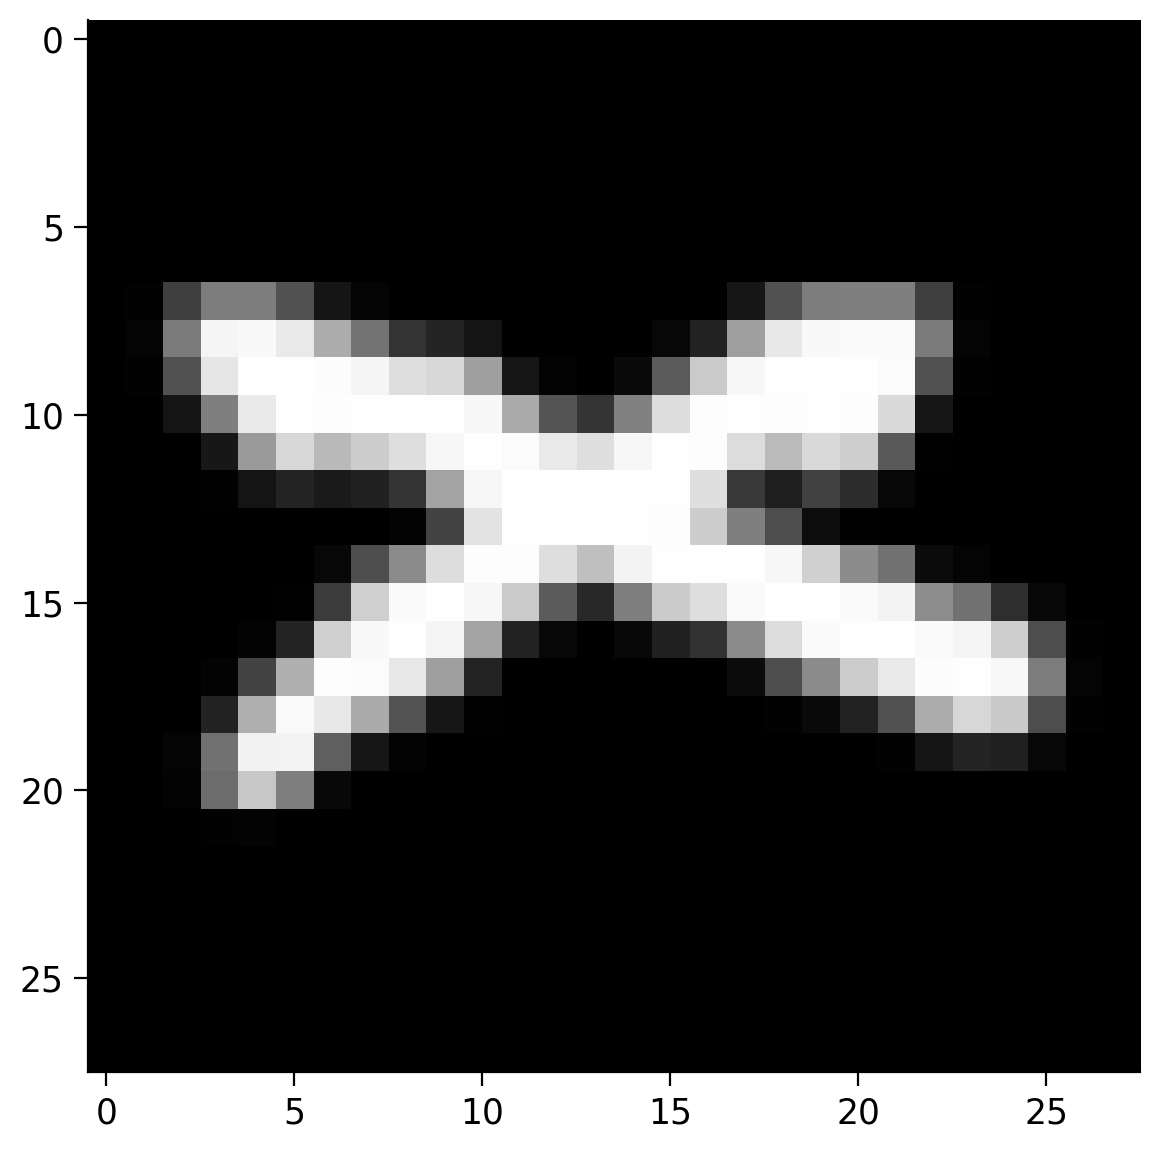

NameError: name 'emnist_net' is not defined

In [41]:
# Index of an image in the dataset that corresponds to an X and O
x_img_idx = 11
o_img_idx = 0

print("Input:")
x_img = emnist_train[x_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[x_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(x_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

The network is quite confident that this image is an $X$!

Note that this is evident from the softmax output, which shows the probabilities of the image belonging to each of the classes. There is a higher probability of belonging to class 1; i.e., class $X$.

Let us also test the network on an $O$ image.

In [ ]:
print("Input:")
o_img = emnist_train[o_img_idx][0].unsqueeze(dim=0).to(DEVICE)
plt.imshow(emnist_train[o_img_idx][0].reshape(28, 28),
           cmap=plt.get_cmap('gray'))
plt.show()
output = emnist_net(o_img)
result = F.softmax(output, dim=1)
print("\nResult:", result)
print("Confidence of image being an 'O':", result[0, 0].item())
print("Confidence of image being an 'X':", result[0, 1].item())

---
# Summary

In this Tutorial we have familiarized ouselves with CNNs. We have leaned how the convolution operation works and be applied in various images. Also, we have learned to implement our own CNN. In the next Tutorial, we will go deeper in the training of CNNs!

---
# Acknowledgement
Material is based on [Neuromatch](https://github.com/NeuromatchAcademy/course-content-dl/tree/main/tutorials)